## Import libraries

In [37]:
import numpy as np
import pandas as pd
import scipy as sc
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

## Read object-feature matrix

In [39]:
data_wisdm = pd.read_table("../data/WISDM/WISDM_ar_v1.1_raw_cleared.txt", delimiter=',')
data_wisdm.columns = ['id_user', 'activity', 'timestamp', 'x', 'y', 'z']

data_uschad = pd.read_table("../data/USC-HAD/USC-HAD_cleared.txt", delimiter=',')
data_uschad.columns = ['id_user', 'activity', 'timestamp', 'x', 'y', 'z']

In [4]:
df_expert_wisdm = pd.read_csv("../data/features/expert_wisdm.csv")
df_ar_wisdm = pd.read_csv("../data/features/ar_wisdm.csv")
df_ssa_wisdm = pd.read_csv("../data/features/ssa_wisdm.csv")

In [5]:
df_expert_uschad = pd.read_csv("../data/features/expert_uschad.csv")
df_ar_uschad = pd.read_csv("../data/features/ar_uschad.csv")
df_ssa_uschad = pd.read_csv("../data/features/ssa_uschad.csv")

# Classification

In [40]:
def get_internal_score(clf, X, y, max_iter=11):
    nb = np.unique(y).shape[0]
    scores = np.zeros(nb+1)
    for j in range(max_iter):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        scores[0] += accuracy_score(y_test, y_predict)
        for i in range(nb):
            scores[i+1] += accuracy_score(1*(np.array(y_test) == i), 
                                          1*(np.array(y_predict) == i))
            
    return scores / max_iter

In [41]:
def get_score(df, estimator, params_grid, test_size=0.3):
    X = df.loc[:, df.columns != 'activity'].values
    y = df['activity'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    clf = GridSearchCV(estimator, params_grid)
    clf.fit(X_train, list(y_train))
    clf_lr = clf.best_estimator_
    scores = get_internal_score(clf_lr, X, list(y))
    
    return scores

## Testing part 

In [42]:
parameters_lr = {'lr__penalty': ['l1', 'l2'], 
                 'lr__class_weight': ['balanced', None], 
                 'lr__C': 10. ** np.arange(-1, 4, 1)}
parameters_svm = {'svc__kernel': ['rbf'], 
                  'svc__C': 10. ** np.arange(-1, 4, 1), 
                  'svc__gamma': 10. ** np.arange(-3, 2, 1),
                  'svc__class_weight': ['balanced', None]}

parameters_rf = {'n_estimators': [200], 
                 'class_weight': ['balanced', None], 
                 'max_depth': [None, 3, 5, 11]}

scores_wisdm = {}
scores_uschad = {}

In [43]:
lr_pipeline = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
svc_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
rfc = RFC()

**Expert** features:

In [37]:
scores_wisdm['lr_expert'] = get_score(df_expert_wisdm, lr_pipeline, parameters_lr)
scores_wisdm['svm_expert'] = get_score(df_expert_wisdm, svc_pipeline, parameters_svm)
scores_wisdm['rf_expert'] = get_score(df_expert_wisdm, rfc, parameters_rf)

In [38]:
scores_uschad['lr_expert'] = get_score(df_expert_uschad, lr_pipeline, parameters_lr)
scores_uschad['svm_expert'] = get_score(df_expert_uschad, svc_pipeline, parameters_svm)
scores_uschad['rf_expert'] = get_score(df_expert_uschad, rfc, parameters_rf)

From **autoregression model** features:

In [10]:
n = 20

In [40]:
scores_wisdm['lr_ar_' + str(n)] = get_score(df_ar_wisdm, lr_pipeline, parameters_lr)
scores_wisdm['svm_ar_' + str(n)] = get_score(df_ar_wisdm, svc_pipeline, parameters_svm)
scores_wisdm['rf_ar_' + str(n)] = get_score(df_ar_wisdm, rfc, parameters_rf)

In [41]:
scores_uschad['lr_ar_' + str(n)] = get_score(df_ar_uschad, lr_pipeline, parameters_lr)
scores_uschad['svm_ar_' + str(n)] = get_score(df_ar_uschad, svc_pipeline, parameters_svm)
scores_uschad['rf_ar_' + str(n)] = get_score(df_ar_uschad, rfc, parameters_rf)

From **spectrum analysis** features:

In [10]:
n = 20

In [43]:
scores_wisdm['lr_ssa_' + str(n)] = get_score(df_ssa_wisdm, lr_pipeline, parameters_lr)
scores_wisdm['svm_ssa_' + str(n)] = get_score(df_ssa_wisdm, svc_pipeline, parameters_svm)
scores_wisdm['rf_ssa_' + str(n)] = get_score(df_ssa_wisdm, rfc, parameters_rf)

In [44]:
scores_uschad['lr_ssa_' + str(n)] = get_score(df_ssa_uschad, lr_pipeline, parameters_lr)
scores_uschad['svm_ssa_' + str(n)] = get_score(df_ssa_uschad, svc_pipeline, parameters_svm)
scores_uschad['rf_ssa_' + str(n)] = get_score(df_ssa_uschad, rfc, parameters_rf)

## Results 

In [74]:
results_wisdm = pd.DataFrame.from_dict(scores_wisdm, orient='index').sort_index()
results_wisdm.columns = ['all'] + list(set(data_wisdm['activity']))
results_wisdm.to_csv("./results/results_wisdm_norm.csv")

results_uschad = pd.DataFrame.from_dict(scores_uschad, orient='index').sort_index()
results_uschad.columns = ['all'] + list(set(data_uschad['activity']))
results_uschad.to_csv("./results/results_uschad_norm.csv")

In [75]:
results_wisdm

,all,Standing,Walking,Upstairs,Sitting,Jogging,Downstairs
lr_ar_20,0.908373,0.983161,0.960247,0.950254,0.980015,0.987417,0.955652
lr_expert,0.854433,0.991149,0.907448,0.908867,0.990069,0.983963,0.927371
lr_ssa_20,0.842005,0.996268,0.861280,0.907016,0.995929,0.987695,0.935821
rf_ar_20,0.928697,0.988065,0.968697,0.956207,0.988157,0.989915,0.966353
rf_expert,0.932953,0.998088,0.958304,0.959322,0.997348,0.987849,0.964996
rf_ssa_20,0.924842,0.996638,0.947880,0.959753,0.996330,0.986307,0.962776
svm_ar_20,0.950594,0.983315,0.981311,0.979368,0.983932,0.993924,0.979337
svm_expert,0.927895,0.991118,0.963115,0.957533,0.991025,0.989823,0.963177
svm_ssa_20,0.953338,0.997995,0.976407,0.973385,0.997348,0.988497,0.973045


In [76]:
results_uschad

,all,Standing,Elevator-up,Walking-forward,Sitting,Walking-downstairs,Sleeping,Elevator-down,Walking-upstairs,Jumping,Walking-right,Walking-left,Running
lr_ar_20,0.650876,0.936495,0.944395,0.865972,0.952501,0.934998,0.979041,0.943446,0.950171,0.990631,0.904425,0.906667,0.993010
lr_expert,0.668135,0.936711,0.940773,0.866197,0.978708,0.950739,1.000000,0.939608,0.943857,0.992648,0.905335,0.894195,0.987499
lr_ssa_20,0.636750,0.923749,0.927332,0.885198,0.939726,0.931229,0.994459,0.941674,0.934635,0.996505,0.908057,0.896407,0.994528
rf_ar_20,0.703025,0.943651,0.946559,0.892785,0.961654,0.957709,0.981654,0.947636,0.948791,0.986314,0.921811,0.925688,0.991796
rf_expert,0.871229,0.975330,0.950426,0.967744,0.991826,0.986177,0.999902,0.949995,0.980822,0.998257,0.973010,0.972227,0.996740
rf_ssa_20,0.840147,0.966618,0.946432,0.962986,0.977230,0.980000,0.995467,0.947068,0.977592,0.997866,0.964023,0.967998,0.997014
svm_ar_20,0.654606,0.942770,0.943054,0.871630,0.960666,0.930269,0.976662,0.943045,0.947234,0.989271,0.901419,0.906853,0.996339
svm_expert,0.797279,0.945022,0.934087,0.945717,0.978326,0.980323,0.999491,0.932658,0.977425,0.997827,0.956828,0.950514,0.996339
svm_ssa_20,0.822320,0.974596,0.940108,0.971375,0.985179,0.980460,0.999540,0.939393,0.983035,0.970005,0.974440,0.973784,0.952726


In [11]:
df_all_wisdm = df_expert_wisdm.join(df_ar_wisdm.iloc[:, 1:])
df_all_wisdm = df_all_wisdm.join(df_ssa_wisdm.iloc[:, 1:])

df_all_uschad = df_expert_uschad.join(df_ar_uschad.iloc[:, 1:])
df_all_uschad = df_all_uschad.join(df_ssa_uschad.iloc[:, 1:])

print(df_all_wisdm.shape, df_all_uschad.shape)

((4321, 164), (13620, 164))


In [12]:
start_time = time.time()
scores_wisdm['lr_all'] = get_score(df_all_wisdm, lr_pipeline, parameters_lr)
print('Logistic regression, all features, WISDM: {:.2f}'.format(time.time() - start_time))
start_time = time.time()
scores_wisdm['svm_all'] = get_score(df_all_wisdm, svc_pipeline, parameters_svm)
print('Support Vector Machine, all features, WISDM: {:.2f}'.format(time.time() - start_time))
start_time = time.time()
scores_wisdm['rf_all'] = get_score(df_all_wisdm, rfc, parameters_rf)
print('Random Forest, all features, WISDM: {:.2f}'.format(time.time() - start_time))

start_time = time.time()
scores_uschad['lr_all'] = get_score(df_all_uschad, lr_pipeline, parameters_lr)
print('Logistic regression, all features, USCHAD: {:.2f}'.format(time.time() - start_time))
start_time = time.time()
scores_uschad['svm_all'] = get_score(df_all_uschad, svc_pipeline, parameters_svm)
print('Support Vector Machine, all features, USCHAD: {:.2f}'.format(time.time() - start_time))
start_time = time.time()
scores_uschad['rf_all'] = get_score(df_all_uschad, rfc, parameters_rf)
print('Random Forest, all features, USCHAD: {:.2f}'.format(time.time() - start_time))

Logistic regression, all features, WISDM: 309.49
Support Vector Machine, all features, WISDM: 366.10
Random Forest, all features, WISDM: 101.38
Logistic regression, all features, USCHAD: 18208.03
Support Vector Machine, all features, USCHAD: 4215.55
Random Forest, all features, USCHAD: 420.34


In [13]:
results_wisdm = pd.DataFrame.from_dict(scores_wisdm, orient='index').sort_index()
results_wisdm.columns = ['all'] + list(set(data_wisdm['activity']))
results_wisdm.to_csv("./results/results_wisdm_all.csv")

results_uschad = pd.DataFrame.from_dict(scores_uschad, orient='index').sort_index()
results_uschad.columns = ['all'] + list(set(data_uschad['activity']))
results_uschad.to_csv("./results/results_uschad_all.csv")

In [14]:
results_wisdm

,all,Standing,Walking,Upstairs,Sitting,Jogging,Downstairs
lr_all,0.956333,0.995374,0.976519,0.972874,0.995654,0.993972,0.978272
rf_all,0.959907,0.998178,0.983248,0.970001,0.997827,0.991729,0.978832
svm_all,0.982687,0.995023,0.992640,0.993061,0.994743,0.996986,0.992921


In [15]:
results_uschad

,all,Standing,Elevator-up,Walking-forward,Sitting,Walking-downstairs,Sleeping,Elevator-down,Walking-upstairs,Jumping,Walking-right,Walking-left,Running
lr_all,0.804009,0.966026,0.947070,0.930850,0.986272,0.972478,0.999755,0.945935,0.979220,0.998242,0.948160,0.938437,0.995572
rf_all,0.881858,0.975103,0.950029,0.973146,0.992747,0.988742,0.999822,0.951631,0.983936,0.998554,0.975749,0.976349,0.997909
svm_all,0.812709,0.965114,0.947381,0.935233,0.986161,0.976349,1.000000,0.946247,0.978285,0.997953,0.952143,0.942843,0.997708


In [37]:
results_wisdm_final = pd.read_csv('./results/results_wisdm_norm.csv', index_col=0)
results_wisdm_all = pd.read_csv('./results/results_wisdm_all.csv', index_col=0)

results_wisdm_final.loc['lr_all'] = results_wisdm_all.loc['lr_all']
results_wisdm_final.loc['svm_all'] = results_wisdm_all.loc['svm_all']
results_wisdm_norm.loc['rf_all'] = results_wisdm_all.loc['rf_all']

results_wisdm_spl = pd.read_csv('./results/results_wisdm_spl.csv', index_col=0)
results_wisdm_final = pd.concat([results_wisdm_final, results_wisdm_spl]).sort_index()

results_wisdm_final.to_csv("./results/results_wisdm_final.csv")

results_wisdm_final

,all,Standing,Walking,Upstairs,Sitting,Jogging,Downstairs
lr_all,0.956333,0.995374,0.976519,0.972874,0.995654,0.993972,0.978272
lr_ar_20,0.908373,0.983161,0.960247,0.950254,0.980015,0.987417,0.955652
lr_expert,0.854433,0.991149,0.907448,0.908867,0.990069,0.983963,0.927371
lr_spl_11,0.581311,0.947294,0.612891,0.892151,0.990779,0.801141,0.918365
lr_ssa_20,0.842005,0.996268,0.861280,0.907016,0.995929,0.987695,0.935821
rf_all,0.934217,0.996577,0.965767,0.953863,0.996207,0.990686,0.965335
rf_ar_20,0.928697,0.988065,0.968697,0.956207,0.988157,0.989915,0.966353
rf_expert,0.932953,0.998088,0.958304,0.959322,0.997348,0.987849,0.964996
rf_spl_11,0.794880,0.986615,0.857024,0.902976,0.997872,0.921079,0.924194
rf_ssa_20,0.924842,0.996638,0.947880,0.959753,0.996330,0.986307,0.962776


In [38]:
results_uschad_final = pd.read_csv('./results/results_uschad_norm.csv', index_col=0)
results_uschad_all = pd.read_csv('./results/results_uschad_all.csv', index_col=0)

results_uschad_final.loc['lr_all'] = results_uschad_all.loc['lr_all']
results_uschad_final.loc['svm_all'] = results_uschad_all.loc['svm_all']
results_uschad_final.loc['rf_all'] = results_uschad_all.loc['rf_all']

results_uschad_spl = pd.read_csv('./results/results_uschad_spl.csv', index_col=0)
results_uschad_final = pd.concat([results_uschad_final, results_uschad_spl]).sort_index()

results_uschad_final.to_csv("./results/results_uschad_final.csv")

results_uschad_final

,all,Standing,Elevator-up,Walking-forward,Sitting,Walking-downstairs,Sleeping,Elevator-down,Walking-upstairs,Jumping,Walking-right,Walking-left,Running
lr_all,0.804009,0.966026,0.947070,0.930850,0.986272,0.972478,0.999755,0.945935,0.979220,0.998242,0.948160,0.938437,0.995572
lr_ar_20,0.650876,0.936495,0.944395,0.865972,0.952501,0.934998,0.979041,0.943446,0.950171,0.990631,0.904425,0.906667,0.993010
lr_expert,0.668135,0.936711,0.940773,0.866197,0.978708,0.950739,1.000000,0.939608,0.943857,0.992648,0.905335,0.894195,0.987499
lr_spl_11,0.414968,0.890073,0.916632,0.703358,0.959373,0.900813,1.000000,0.912580,0.923749,0.965570,0.857670,0.877543,0.922575
lr_ssa_20,0.636750,0.923749,0.927332,0.885198,0.939726,0.931229,0.994459,0.941674,0.934635,0.996505,0.908057,0.896407,0.994528
rf_all,0.881858,0.975103,0.950029,0.973146,0.992747,0.988742,0.999822,0.951631,0.983936,0.998554,0.975749,0.976349,0.997909
rf_ar_20,0.703025,0.943651,0.946559,0.892785,0.961654,0.957709,0.981654,0.947636,0.948791,0.986314,0.921811,0.925688,0.991796
rf_expert,0.871229,0.975330,0.950426,0.967744,0.991826,0.986177,0.999902,0.949995,0.980822,0.998257,0.973010,0.972227,0.996740
rf_spl_11,0.736495,0.978600,0.946070,0.883524,0.992697,0.954763,1.000000,0.947890,0.959520,0.987479,0.924268,0.925884,0.972296
rf_ssa_20,0.840147,0.966618,0.946432,0.962986,0.977230,0.980000,0.995467,0.947068,0.977592,0.997866,0.964023,0.967998,0.997014


### Results for presentation 

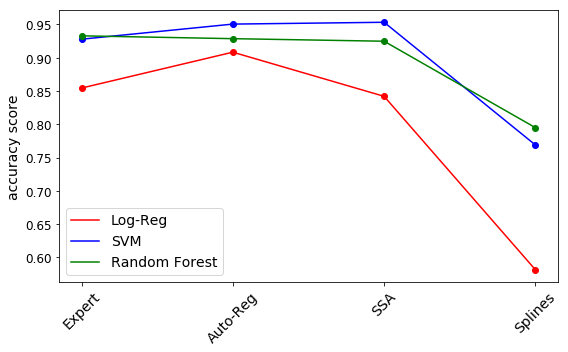

In [68]:
tmp = results_wisdm_final.loc[:, 'all']
lines = []
c = ['r', 'b', 'g']

for method in ['lr', 'svm', 'rf']:
    lines.append([tmp[method + '_expert'], 
                  tmp[method + '_ar_20'], 
                  tmp[method + '_ssa_20'], 
                  tmp[method + '_spl_11']])
    
ticks = ['Expert', 'Auto-Reg', 'SSA', 'Splines']

plt.figure(figsize=(8, 5))

plt.plot(range(4), lines[0], c=c[0], label='Log-Reg')
plt.plot(range(4), lines[0], 'o', c=c[0])
plt.plot(range(4), lines[1], c=c[1], label='SVM')
plt.plot(range(4), lines[1], 'o', c=c[1])
plt.plot(range(4), lines[2], c=c[2], label='Random Forest')
plt.plot(range(4), lines[2], 'o', c=c[2])
    
plt.legend(fontsize=14)
plt.xticks(range(4), ticks, rotation=45, fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('accuracy score', fontsize=14)
plt.tight_layout()
plt.savefig('./../doc/wisdm_methods.png')
plt.show()

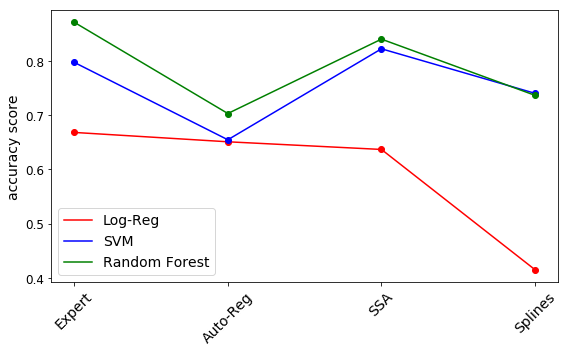

In [67]:
tmp = results_uschad_final.loc[:, 'all']
lines = []
c = ['r', 'b', 'g']

for method in ['lr', 'svm', 'rf']:
    lines.append([tmp[method + '_expert'], 
                  tmp[method + '_ar_20'], 
                  tmp[method + '_ssa_20'], 
                  tmp[method + '_spl_11']])
    
ticks = ['Expert', 'Auto-Reg', 'SSA', 'Splines']

plt.figure(figsize=(8, 5))

plt.plot(range(4), lines[0], c=c[0], label='Log-Reg')
plt.plot(range(4), lines[0], 'o', c=c[0])
plt.plot(range(4), lines[1], c=c[1], label='SVM')
plt.plot(range(4), lines[1], 'o', c=c[1])
plt.plot(range(4), lines[2], c=c[2], label='Random Forest')
plt.plot(range(4), lines[2], 'o', c=c[2])
    
plt.legend(fontsize=14)
plt.xticks(range(4), ticks, rotation=45, fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('accuracy score', fontsize=14)
plt.tight_layout()
plt.savefig('./../doc/uschad_methods.png')
plt.show()

# MARS

In [47]:
df_mars_wisdm = pd.read_csv("../data/features/mars_wisdm.csv")
df_mars_wisdm.head()

,Activity,0,1,2,3,4,5,6,7,8,...,41.2,42.2,43.2,44.2,45.2,46.2,47.2,48.2,49.2,50.2
0,1,-0.000126,-0.000928,0.010653,-0.000019,0.077093,0.157060,-0.000003,-0.000084,-0.000085,...,0.000970,-0.000297,-0.000681,-0.000200,0.000310,0.002625,0.000168,0.000119,0.000970,-0.001550
1,4,-0.013218,-0.095633,1.118979,-0.001408,8.097835,16.488682,-0.000674,-0.010782,-0.009443,...,0.085361,-0.030745,-0.083985,0.003834,0.030998,0.325277,0.020636,0.127396,0.085361,-0.195227
2,1,-0.022087,-0.156020,1.874878,-0.001083,13.568309,27.626778,-0.001895,-0.022570,-0.017128,...,0.083978,-0.021257,-0.035560,-0.042789,0.011750,0.156360,-0.003095,-0.105806,0.083978,-0.063730
3,1,0.019018,0.132503,-1.616909,0.000282,-11.701115,-23.816517,0.001989,0.021634,0.015289,...,-0.344491,0.105864,0.234886,0.076705,-0.087981,-0.918786,-0.047762,0.007656,-0.344491,0.564579
4,3,0.009907,0.071633,-0.838690,0.001084,-6.069394,-12.357942,0.000522,0.008142,0.007130,...,-0.014174,0.003490,0.007597,0.000248,-0.001807,-0.022567,-0.007945,0.013145,-0.014174,0.015814


In [48]:
df_mars_wisdm.shape

(432, 154)

In [55]:
start_time = time.time()
scores_wisdm['lr_mars'] = get_score(df_mars_wisdm, lr_pipeline, parameters_lr)
print('Logistic regression, MARS features, WISDM: {:.2f}'.format(time.time() - start_time))
start_time = time.time()
scores_wisdm['svm_mars'] = get_score(df_mars_wisdm, svc_pipeline, parameters_svm)
print('Support Vector Machine, MARS features, WISDM: {:.2f}'.format(time.time() - start_time))
start_time = time.time()
scores_wisdm['rf_mars'] = get_score(df_mars_wisdm, rfc, parameters_rf)
print('Random Forest, MARS features, WISDM: {:.2f}'.format(time.time() - start_time))

Logistic regression, MARS features, WISDM: 207.69
Support Vector Machine, MARS features, WISDM: 6.66
Random Forest, MARS features, WISDM: 30.03


In [56]:
results_wisdm = pd.DataFrame.from_dict(scores_wisdm, orient='index').sort_index()
results_wisdm.columns = ['all'] + list(set(data_wisdm['activity']))
results_wisdm.to_csv("./results/results_wisdm_mars.csv")

results_wisdm

,all,Standing,Walking,Upstairs,Sitting,Jogging,Downstairs
lr_mars,0.438462,0.958741,0.446154,0.891608,0.944755,0.740559,0.895105
rf_mars,0.415385,0.959441,0.494406,0.854545,0.951049,0.681818,0.889510
svm_mars,0.465035,0.953147,0.465035,0.886713,0.954545,0.762238,0.908392


In [46]:
results_wisdm = pd.DataFrame.from_dict(scores_wisdm, orient='index').sort_index()
results_wisdm.columns = ['all'] + list(set(data_wisdm['activity']))
results_wisdm.to_csv("./results/results_wisdm_mars.csv")

results_wisdm

,all,Standing,Walking,Upstairs,Sitting,Jogging,Downstairs
lr_mars,0.507692,0.932168,0.518182,0.884615,0.933566,0.813986,0.932867
rf_mars,0.644755,0.925175,0.720979,0.876224,0.936364,0.893007,0.937762
svm_mars,0.578322,0.915385,0.718881,0.844056,0.925874,0.849650,0.902797
